# Fisheries restoration potential data  
This notebook contains the initial exploration for the fisheries data (potential increase in population of commercial marine species from restoring the mangrove areas), as well as the data processing for the widget/s

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import fiona


## 1) Data exploration

In [3]:
path_in = 'https://storage.googleapis.com/mangrove_atlas/widget_data'
data_df = pd.read_csv(f'{path_in}/Vizz_Country_Stats_Dec2022.csv', index_col=0)
data_df = data_df[['Name', 'Total_Fish','Fish','Crab','Bivalve','Shrimp']]
data_df.head()


,Name,Total_Fish,Fish,Crab,Bivalve,Shrimp
1,American Samoa,9.129377e+03,9081.125331,4.825178e+01,0.0,0.0
2,Angola,4.553915e+04,45539.145920,0.000000e+00,0.0,0.0
3,Anguilla,2.378690e+04,10165.451040,1.362145e+04,0.0,0.0
4,Antigua and Barbuda,2.045093e+06,873980.752300,1.171113e+06,0.0,0.0
5,Aruba,8.612742e+04,36806.980660,4.932044e+04,0.0,0.0


In [3]:
# General data description
data_df.describe()

,Total_Fish,Fish,Crab,Bivalve,Shrimp
count,1.100000e+02,1.100000e+02,1.100000e+02,1.100000e+02,1.100000e+02
mean,4.774990e+08,1.751649e+08,3.187175e+07,2.096493e+07,2.494974e+08
std,2.145820e+09,8.093077e+08,1.107056e+08,1.030600e+08,1.330342e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.678605e+05,1.920563e+05,3.772662e+03,0.000000e+00,0.000000e+00
50%,5.653750e+06,2.712518e+06,1.057261e+05,0.000000e+00,0.000000e+00
75%,1.073200e+08,3.988543e+07,4.212177e+06,0.000000e+00,4.798984e+06
max,2.128727e+10,8.033452e+09,6.715925e+08,7.178544e+08,1.321201e+10


In [8]:
# Countries with no fisheries values
data_df[data_df['Total_Fish'] == 0]

,Name,Total_Fish,Fish,Crab,Bivalve,Shrimp
34,Egypt,0.0,0.0,0.0,0.0,0.0


In [11]:
# Countries with Bivalve values >0
print(f'Countries with Bivalve > 0: {len(data_df[data_df["Bivalve"] > 0])}')
display(data_df[data_df['Bivalve'] > 0])

Countries with Bivalve > 0: 10


,Name,Total_Fish,Fish,Crab,Bivalve,Shrimp
21,Colombia,6.004840e+08,2.053468e+08,3.494403e+08,4.569697e+07,0.0
26,Costa Rica,1.117791e+08,8.855887e+06,2.593636e+07,7.698686e+07,0.0
33,Ecuador,1.057041e+09,8.921979e+07,2.499667e+08,7.178544e+08,0.0
35,El Salvador,5.619665e+07,4.452274e+06,1.303944e+07,3.870494e+07,0.0
48,Guatemala,8.793437e+07,7.038908e+06,2.047507e+07,6.042039e+07,0.0
53,Honduras,3.887455e+08,3.561137e+07,9.521227e+07,2.579218e+08,0.0
70,Mexico,1.818883e+09,4.348259e+08,6.715925e+08,7.124647e+08,0.0
76,Nicaragua,4.779696e+08,4.466271e+07,1.175524e+08,3.157544e+08,0.0
81,Panama,3.750960e+07,4.026944e+06,9.748433e+06,2.373422e+07,0.0
83,Peru,8.412071e+07,7.770396e+06,1.974691e+07,5.660340e+07,0.0


Countries with Shrimp > 0: 45


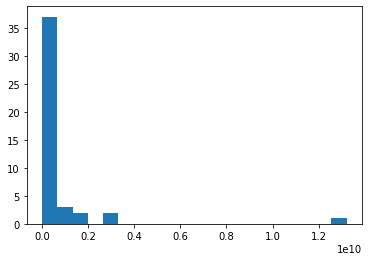

In [18]:
# Countries with Shrimp values >0
print(f'Countries with Shrimp > 0: {len(data_df[data_df["Shrimp"] > 0])}')
plt.hist(data_df[data_df['Shrimp'] > 0]['Shrimp'], bins=20)
plt.show()

In [30]:
#Cases with values >0 per category

pd.DataFrame({'Total': len(data_df),
              'Fish >0': len(data_df[data_df['Fish'] > 0]),
              'Crab >0': len(data_df[data_df['Crab'] > 0]),
              'Bivalve >0': len(data_df[data_df['Bivalve'] > 0]),
              'Shrimp >0': len(data_df[data_df['Shrimp'] > 0]),
              'All >0': len(data_df[(data_df['Fish'] > 0) & (data_df['Crab'] > 0) & (data_df['Bivalve'] > 0) & (data_df['Shrimp'] > 0)])}, index=[0])

,Total,Fish >0,Crab >0,Bivalve >0,Shrimp >0,All >0
0,122,109,92,10,45,0


In [28]:
# Categories with values >0 per country

country_test = data_df.copy()
country_test.drop(columns=['Total_Fish'], inplace=True)
country_test['Fish'] = np.where(country_test['Fish'] > 0, 1, 0)
country_test['Crab'] = np.where(country_test['Crab'] > 0, 1, 0)
country_test['Bivalve'] = np.where(country_test['Bivalve'] > 0, 1, 0)
country_test['Shrimp'] = np.where(country_test['Shrimp'] > 0, 1, 0)
country_test['Total'] = country_test['Fish'] + country_test['Crab'] + country_test['Bivalve'] + country_test['Shrimp']
country_test.sort_values(by='Total', ascending=True)

,Name,Fish,Crab,Bivalve,Shrimp,Total
25,Cook Islands,0,0,0,0,0
92,Sao Tome and Principe,0,0,0,0,0
29,Curaçao,0,0,0,0,0
98,Sint Maarten,0,0,0,0,0
34,Egypt,0,0,0,0,0
...,...,...,...,...,...,...
84,Philippines,1,1,0,1,3
86,Qatar,1,1,0,1,3
48,Guatemala,1,1,1,0,3
22,Comoros,1,1,0,1,3


In [29]:
# How many countries have 0-3 categories with values >0?
country_test['Total'].value_counts()

3    55
2    37
1    17
0    13
Name: Total, dtype: int64

**Some initial remarks**  
- Only 10 countries (less than 10% of total) have values for ```Bivalve```, all of them in Central and South America  
- \>50% of the data has 0 value for ```Shrimp```. Distribution of >0 values is notably sekewed left  
- No country has values >0 on all 4 categories

### Prepare dataset for interactive mock-up

In [4]:
t_df = data_df[['Name', 'Fish', 'Crab', 'Shrimp', 'Bivalve']].copy()
tableau_data = t_df.melt(id_vars='Name', var_name='Category', value_name='Value')
tableau_data.head()


,Name,Category,Value
0,American Samoa,Fish,9081.125331
1,Angola,Fish,45539.145920
2,Anguilla,Fish,10165.451040
3,Antigua and Barbuda,Fish,873980.752300
4,Aruba,Fish,36806.980660


In [8]:
tableau_data[tableau_data.Value.notnull()].to_csv('../../../../data/fisheries_tableau_data.csv', index=False)

In [14]:
t_df['Total'] = t_df['Fish'] + t_df['Crab'] + t_df['Shrimp'] + t_df['Bivalve']
t_df['Fish_pct'] = (t_df['Fish'] / t_df['Total'])*100
t_df['Crab_pct'] = (t_df['Crab'] / t_df['Total'])*100
t_df['Shrimp_pct'] = (t_df['Shrimp'] / t_df['Total'])*100
t_df['Bivalve_pct'] = (t_df['Bivalve'] / t_df['Total'])*100
t_df

,Name,Fish,Crab,Shrimp,Bivalve,Total,Fish_pct,Crab_pct,Shrimp_pct,Bivalve_pct
1,American Samoa,9.081125e+03,4.825178e+01,0.000000e+00,0.0,9.129377e+03,99.471467,0.528533,0.000000,0.0
2,Angola,4.553915e+04,0.000000e+00,0.000000e+00,0.0,4.553915e+04,100.000000,0.000000,0.000000,0.0
3,Anguilla,1.016545e+04,1.362145e+04,0.000000e+00,0.0,2.378690e+04,42.735495,57.264505,0.000000,0.0
4,Antigua and Barbuda,8.739808e+05,1.171113e+06,0.000000e+00,0.0,2.045093e+06,42.735495,57.264505,0.000000,0.0
5,Aruba,3.680698e+04,4.932044e+04,0.000000e+00,0.0,8.612742e+04,42.735495,57.264505,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
118,Vietnam,8.003055e+08,4.264494e+06,1.323569e+09,0.0,2.128139e+09,37.605885,0.200386,62.193729,0.0
119,British Virgin Islands,1.973156e+05,2.643980e+05,0.000000e+00,0.0,4.617137e+05,42.735495,57.264505,0.000000,0.0
120,"Virgin Islands, U.S.",3.632265e+05,4.867145e+05,0.000000e+00,0.0,8.499410e+05,42.735495,57.264505,0.000000,0.0
121,Wallis and Futuna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


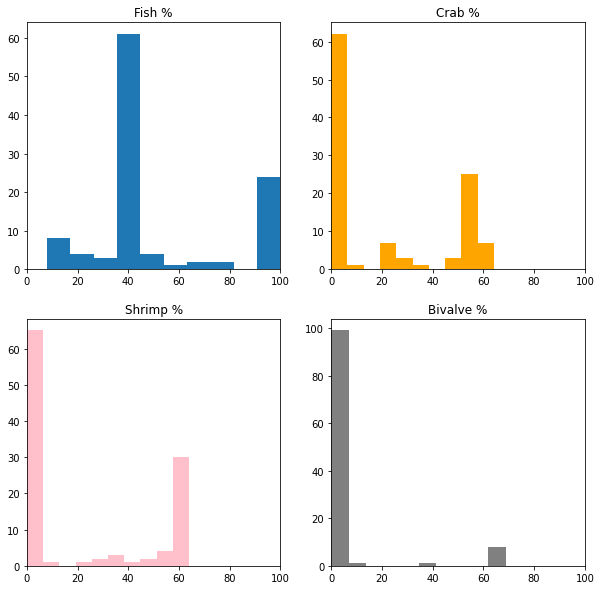

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(t_df['Fish_pct'], bins=10)
axs[0, 0].set_title('Fish %')
axs[0, 0].set_xlim([0, 100])

axs[0, 1].hist(t_df['Crab_pct'], bins=10, color='orange')
axs[0, 1].set_title('Crab %')
axs[0, 1].set_xlim([0, 100])

axs[1, 0].hist(t_df['Shrimp_pct'], bins=10, color='pink')
axs[1, 0].set_title('Shrimp %')
axs[1, 0].set_xlim([0, 100])

axs[1, 1].hist(t_df['Bivalve_pct'], bins=10, color='gray')
axs[1, 1].set_title('Bivalve %')
axs[1, 1].set_xlim([0, 100])

plt.show()
